In [1]:
!git clone https://github.com/NVlabs/edm
!bash /content/stargan-v2/download.sh celeba-hq-dataset
!git clone https://github.com/clovaai/stargan-v2.git
!cd stargan-v2/
!git clone https://github.com/NVlabs/edm
# !pip install lpips

import lpips
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import make_grid
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings('ignore')
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor
import sys
sys.path.append('edm')
sys.path.append('edm/training/')
sys.path.append('edm/training/networks')

import pickle
from edm.dnnlib import util
from torch_utils import misc
from cunet import CUNet

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

from IPython.display import clear_output

import random

 # Importing data 

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root= '/content/data/celeba_hq/train', transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True,)

In [10]:
model = CUNet(in_channels=3, out_channels=3, noise_channels=128, base_factor=80, emb_channels=128).to('cuda')


sampling_params = {
    'device': 'cuda',
    'num_steps': 100,
}

print(f"Модель имеет {sum(p.numel() for p in model.parameters())} параметров")

Модель имеет 27318387 параметров


## I2IBM Replication

In [11]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    beta_start = 0.0001
    beta_end = 0.3/num_diffusion_timesteps
    if schedule_name == "linear":
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps,  dtype=torch.float64
        )
    elif schedule_name == "quad":
        betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=torch.float64) ** 2
        return betas
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")
    
def get_named_beta_schedule_triag(schedule_name, num_diffusion_timesteps):
    betas = get_named_beta_schedule(schedule_name, num_diffusion_timesteps)
    betas = torch.concatenate([betas[:len(betas)//2], torch.flip(betas[:len(betas)//2], dims = (0,))])
    return betas

def corruption(x, kernel_size=7, sigma=2):
    blur = transforms.GaussianBlur(kernel_size, sigma)
    blurred_image = blur.forward(x)
    return blurred_image



In [339]:
class I2B:
    def __init__(self, betas, params):
        self.params = params
        self.betas = betas.to(self.params['device'])
        self.betas = self.betas

        self.sigma = torch.sqrt(torch.cumsum(self.betas, dim=0))
        self.sigma_conj = torch.sqrt(torch.cumsum(self.betas.flip(dims=(0,)), dim=0).flip(dims=(0,)))
        self.saved_story = []

    def q_sample(self, x_0, t):
        sigma1 = self.sigma[t]
        sigma2 = self.sigma_conj[t]
        mean1 = sigma2**2 / (sigma1**2 + sigma2**2)
        mean2 = sigma1**2 / (sigma1**2 + sigma2**2)
        var = (sigma1**2 * sigma2**2) / (sigma1**2 + sigma2**2)

        x_1 = corruption(x_0)
        noise = torch.randn_like(x_0)

        return mean1 * x_0 + mean2 * x_1 + torch.sqrt(var) * noise

    def p_sample(self, x_0_pred, x_next, n):
        alpha = torch.sqrt(self.sigma[n + 1]**2 - self.sigma[n]**2)
        sigma = self.sigma[n]
        mean1 = alpha**2/(alpha**2 + sigma**2)
        mean2 = sigma**2/(alpha**2 + sigma**2)
        var = (alpha**2 * sigma**2) / (alpha**2 + sigma**2)

        noise = torch.randn_like(x_0_pred)

        return mean1 * x_0_pred + mean2 * x_next + torch.sqrt(var) * noise

    def _predict_xstart_from_eps(self, t, x_t, eps):
        sigma_t = self.sigma[t]
        pred_x0 = x_t - sigma_t * eps
        return pred_x0

    def p_sample_loop(self, model, x):
        x = x
        shape = x.shape
        self.saved_story = []
        for i in tqdm(reversed(range(self.params['num_steps'] - 1))):
            with torch.no_grad():
                model_output = model(x, torch.tensor(i).unsqueeze(0).cuda(), None)
                pred_x0 = self._predict_xstart_from_eps(i, x, model_output)
                x = self.p_sample(pred_x0, x, i)
                if i in {98, 95, 90, 75, 50, 25, 10, 0}:
                    self.saved_story.append(x)

        return x

    def train_loss(self, model, x_0):
        t = random.randint(0, self.params['num_steps']-1)
        sigma = self.sigma[t]
        x_t = self.q_sample(x_0, t)
        model_output = model(x_t, torch.tensor(t).unsqueeze(0).cuda(), None)
        loss = ((model_output - (x_t - x_0)/sigma) ** 2).mean()
        return loss


## Training

In [342]:
class Trainer:
    def __init__(
        self,
        diffusion,
        model,
        train_iter,
        num_epochs,
        lr: float,
        weight_decay: float,
        device: torch.device = torch.device('cuda')
    ):
        self.num_epochs = num_epochs
        self.diffusion = diffusion

        self.train_iter = train_iter
        self.init_lr = lr
        self.model = model
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        self.device = device
        self.print_every = 200
        self.save_info_every = 25
        self.metrics = True
        self.save_metrics_every= 100
    def _anneal_lr(self, step: int, max_steps):

        frac_done = step / max_steps
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x: torch.FloatTensor):

        loss = self.diffusion.train_loss(self.model, x)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()


        return loss

    def run_loop(self):
        curr_loss_gauss = 0.0

        curr_count = 0
        loss_list = []
        loss_lpips = []
        loss_mse = []
        step = 0

        loss_fn_alex = lpips.LPIPS(net='alex').to('cuda')

        for epoch in range(self.num_epochs):

          for data in self.train_iter:

              x, _ = data

              x = x.to('cuda')
              batch_loss = self._run_step(x)

              curr_count += len(x)
              curr_loss_gauss += batch_loss.item() * len(x)

              if (step + 1) % self.save_info_every == 0:
                  gloss = np.around(curr_loss_gauss / curr_count , 4)
                  loss_list.append(gloss)
                  curr_count = 0
                  curr_loss_gauss = 0.0
                  if loss_list[-1] < 0.06:

                      torch.save(self.model.state_dict(), 'weights_final')



              if self.metrics == True and (step + 1) % self.save_metrics_every == 0:
                  x_blured = corruption(x)
                  x_unblured = self.diffusion.p_sample_loop(self.model, x_blured)
                  loss_lpips.append( float(loss_fn_alex(x, x_unblured)[0][0][0][0]))

                  loss_mse.append( float(((x - x_unblured)**2).mean()))



              if (step + 1) % self.print_every == 0:
                  clear_output(wait=True)
                  print(f'Epoch is {epoch}/{self.num_epochs}, step is {(step + 1) % len(self.train_iter)}/{len(self.train_iter)}')


                  if self.metrics == True:
                      fig_loss, (ax_loss1, ax_loss2, ax_loss3) = plt.subplots(1, 3)
                      fig_loss.set_size_inches(15, 5)

                      ax_loss1.plot(loss_list)
                      ax_loss1.title.set_text('Model Loss')

                      ax_loss2.plot(loss_lpips)
                      ax_loss2.title.set_text('Lpips Loss')

                      ax_loss3.plot(loss_mse)
                      ax_loss3.title.set_text('MSE Loss')

                  else:
                      plt.plot(loss_list)
                  plt.show()


                  num_photo = random.randint(0, len(data)-1)
                  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,15))
                  images_blured = corruption(x[num_photo].unsqueeze(0))
                  unblured_x = self.diffusion.p_sample_loop(self.model, images_blured)
                  out = ((2 * unblured_x - 1)  * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
                  ax3.imshow(out[0])
                  ax3.title.set_text('Unblured photo')
                  ax2.imshow(corruption(data[0][num_photo]).permute(1, 2, 0) )
                  ax2.title.set_text('Blured photo')
                  ax1.imshow(data[0][num_photo].permute(1, 2, 0) )
                  ax1.title.set_text('Original photo')

                  plt.show()



              step += 1
          self._anneal_lr(1, 10)


In [344]:

diffusion = I2B(
    betas=get_named_beta_schedule_triag('quad', sampling_params['num_steps']),
    params = sampling_params)

trainer = Trainer(
    diffusion,
    model,
    num_epochs = 40,
    train_iter=dataloader,
    lr=1e-5,
    weight_decay=0,)

Epoch is 5/40, step is 25/875


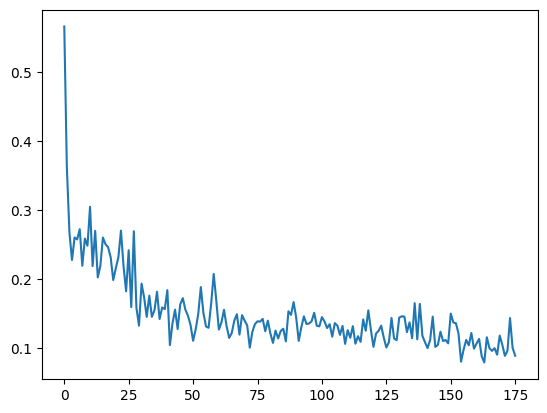

99it [00:00, 165.12it/s]


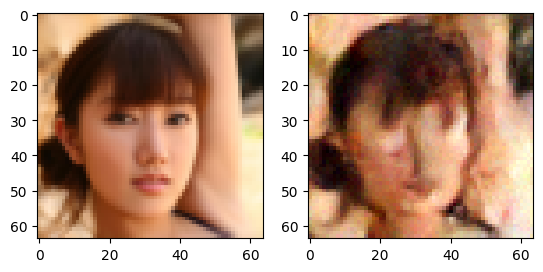

KeyboardInterrupt: 

In [ ]:

trainer.run_loop()

Epoch is 13/40, step is 225/875


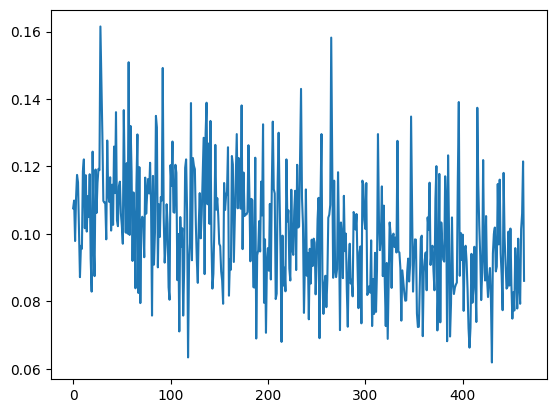

99it [00:00, 161.20it/s]


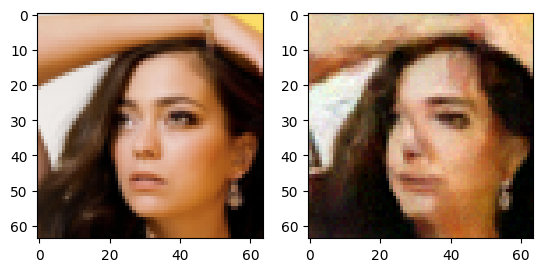

KeyboardInterrupt: 

In [ ]:

trainer.run_loop()

Epoch is 8/40, step is 200/875


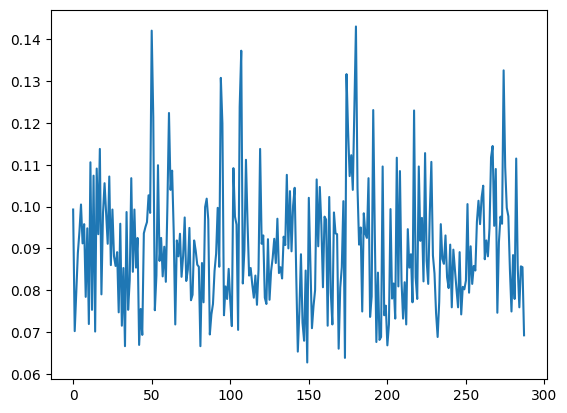

99it [00:00, 161.95it/s]


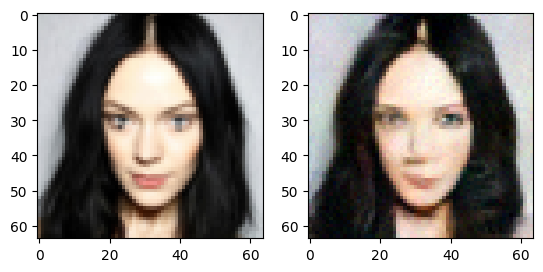

KeyboardInterrupt: 

In [ ]:

trainer.run_loop()

Epoch is 7/40, step is 675/875


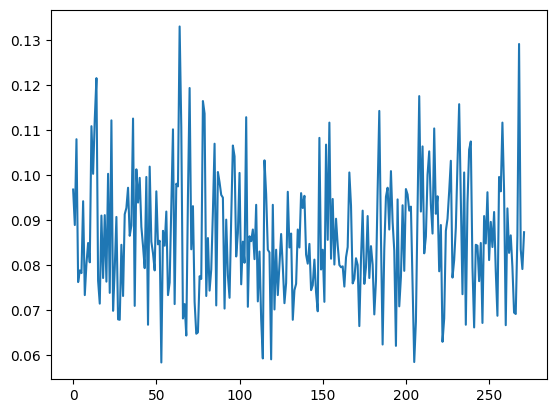

99it [00:00, 114.46it/s]


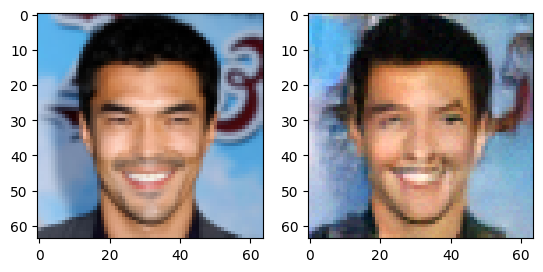

KeyboardInterrupt: 

In [ ]:

trainer.run_loop()

Epoch is 9/40, step is 125/875


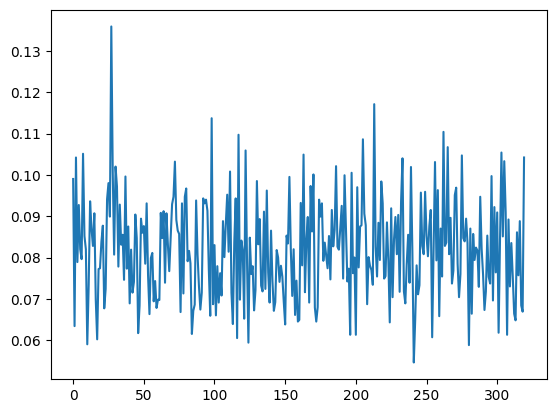

99it [00:00, 127.22it/s]


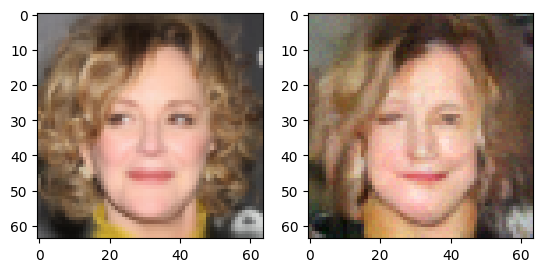

KeyboardInterrupt: 

In [ ]:
trainer.run_loop()

Epoch is 11/40, step is 775/875


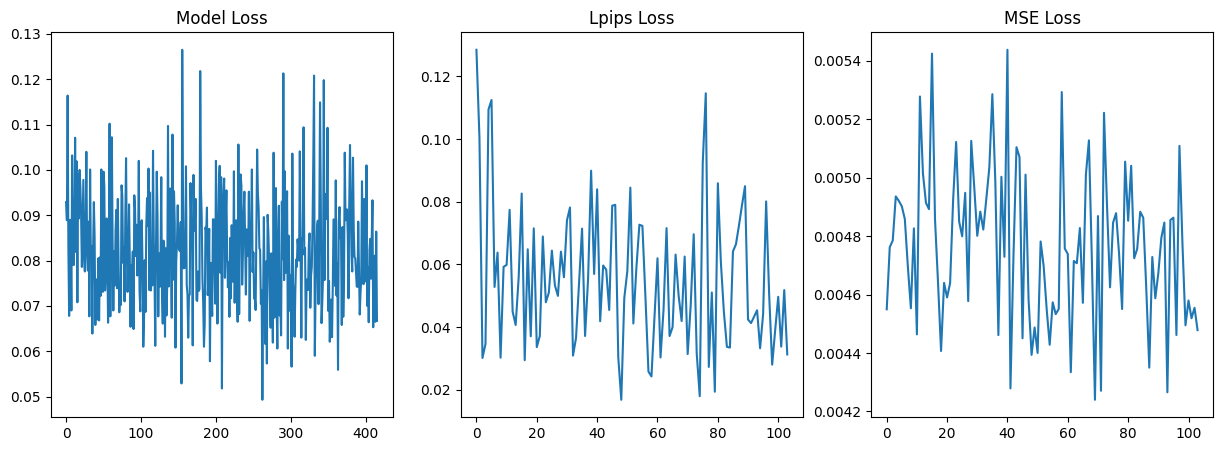

99it [00:00, 164.14it/s]


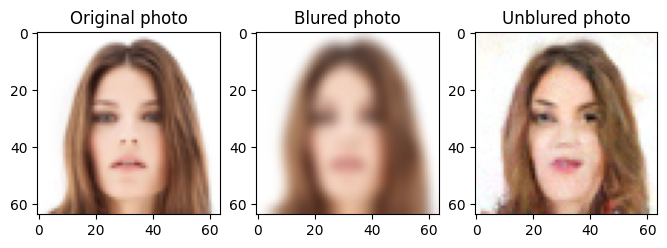

KeyboardInterrupt: 

In [ ]:
trainer.run_loop()

Epoch is 4/40, step is 500/875


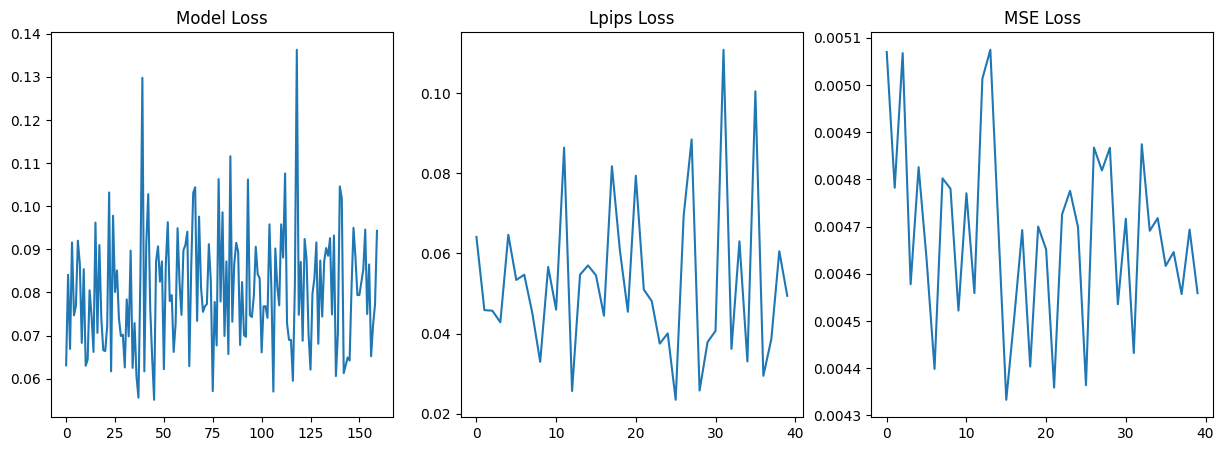

99it [00:00, 150.87it/s]


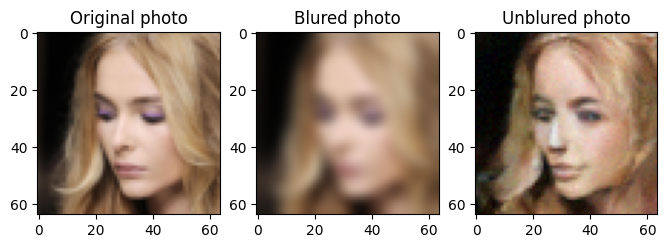

99it [00:06, 15.48it/s]


In [ ]:
trainer.run_loop()

In [ ]:
model.load_state_dict(torch.load('weights_final'))


# Test metrics

In [21]:
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
from dnnlib.util import open_url
from edm.dnnlib import util
def calc_fid(image_path, ref_path, num_expected, batch):
    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    ref_mu, ref_sigma = calculate_inception_stats(image_path=ref_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref_mu, ref_sigma)
    return fid

In [22]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])
test_dataset = datasets.ImageFolder(root= '/content/data/celeba_hq/val', transform=transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [23]:
len(test_dataset)

2000

In [24]:
import shutil

# Define paths for the source folders
folder1 = "/content/data/celeba_hq/val/male"  # Replace with the path to your first folder
folder2 = "/content/data/celeba_hq/val/female"  # Replace with the path to your second folder

# Define the path for the new destination folder
new_folder = "/content/united_val"

# Create the new folder if it doesn't exist
os.makedirs(new_folder, exist_ok=True)

# Function to copy files from one folder to another
def copy_files(source_folder, destination_folder):
    for root, _, files in os.walk(source_folder):
        for file in files:
            source_file = os.path.join(root, file)
            destination_file = os.path.join(destination_folder, file)

            # Copy file
            shutil.copy2(source_file, destination_file)

# Copy contents of folder1 and folder2 to the new_folder
copy_files(folder1, new_folder)
copy_files(folder2, new_folder)


In [25]:
import os
name = 'model_samples'
if os.path.exists(name):
    shutil.rmtree(name)
os.makedirs(name, exist_ok=True)
count = 0
import os, shutil


model.eval()

loss_lpips = lpips.LPIPS(net='alex').to('cuda')
# best forward scores

lpips = 0.
lpips_baseline = 0.
mse = 0.
mse_baseline = 0.


with torch.no_grad():
  for batch in tqdm(test_dataloader):
      real_images = batch[0].to('cuda')
      images_blured = corruption(batch[0]).to('cuda')
      deblured_image  = diffusion.p_sample_loop(model, images_blured)

      mse += ((real_images - deblured_image)**2).mean() * batch[0].shape[0]
      mse_baseline += ((real_images - images_blured)**2).mean() * batch[0].shape[0]
      lpips += loss_lpips(real_images, deblured_image).sum()
      lpips_baseline += loss_lpips(real_images, images_blured).sum()

      out = ((2 * deblured_image - 1)  * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
      for i in range(out.shape[0]):
          image = batch[0][i]

          img = Image.fromarray(out[i])
          n_digits = len(str(count))
          img_name = (6 - n_digits) * '0' + str(count) + '.png'
          img.save(os.path.join(name, img_name))
          count += 1
      clear_output()




100%|██████████| 63/63 [07:00<00:00,  6.68s/it]


In [43]:
import os
name = 'blur_samples'
if os.path.exists(name):
    shutil.rmtree(name)
os.makedirs(name, exist_ok=True)
count = 0
import os, shutil


model.eval()

# best forward scores


with torch.no_grad():
  for batch in tqdm(test_dataloader):
      real_images = batch[0].to('cuda')
      images_blured = corruption(batch[0]).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
      for i in range(images_blured.shape[0]):

          img = Image.fromarray(images_blured[i])
          n_digits = len(str(count))
          img_name = (6 - n_digits) * '0' + str(count) + '.png'
          img.save(os.path.join(name, img_name))
          count += 1
      clear_output()




100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


In [27]:
fid = calc_fid('/content/model_samples', '/content/united_val', num_expected=2000, batch=128)

Loading Inception-v3 model...
Loading images from "/content/model_samples"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:07<00:00,  2.13batch/s]


Loading Inception-v3 model...
Loading images from "/content/united_val"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:23<00:00,  1.49s/batch]


In [44]:
fid_blur = calc_fid('/content/blur_samples', '/content/united_val', num_expected=2000, batch=128)

Loading Inception-v3 model...
Loading images from "/content/blur_samples"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:07<00:00,  2.17batch/s]


Loading Inception-v3 model...
Loading images from "/content/united_val"...
Calculating statistics for 2000 images...


100%|██████████| 16/16 [00:22<00:00,  1.44s/batch]


In [28]:
lpips_fin, lpips_baseline_fin = lpips / len(test_dataset), lpips_baseline / len(test_dataset)
mse_fin, mse_baseline_fin = mse / len(test_dataset), mse_baseline / len(test_dataset)

print(f'Baseline MSE: {mse_baseline_fin} vs MSE: {mse_fin}')
print(f'Baseline LPIPS: {lpips_baseline_fin} vs LPIPS: {lpips_fin}')
print(f'FID {fid}')


Baseline MSE: 0.0042806826531887054 vs MSE: 0.004626729525625706
Baseline LPIPS: 0.2990046441555023 vs LPIPS: 0.049100276082754135
FID 157.2890380584886


In [45]:
print(f'Fid for Blur images: {fid_blur}')

Fid for Blur images: 571.9014964012504


## Image generation

In [415]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])
test_dataset = datasets.ImageFolder(root= '/content/data/celeba_hq/val', transform=transform)

test_dataloader_batch8 = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle = True)

for j in test_dataloader_batch8:
  _ = 1
  break

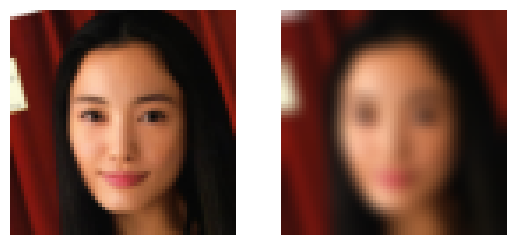

In [416]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)



ax1.imshow(j[0][0].permute(1, 2, 0))
ax2.imshow(corruption(j[0][0]).permute(1, 2, 0))

ax1.axis('off')
ax2.axis('off')
plt.savefig('show_blur.pdf')
plt.show()


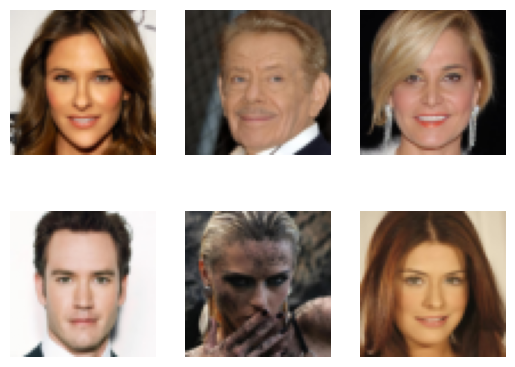

In [401]:


fig, ax = plt.subplots(2, 3)

ax[0, 0].imshow(j[0][0].permute(1, 2, 0))
ax[0, 1].imshow(j[0][1].permute(1, 2, 0))
ax[0, 2].imshow(j[0][2].permute(1, 2, 0))
ax[1, 0].imshow(j[0][3].permute(1, 2, 0))
ax[1, 1].imshow(j[0][4].permute(1, 2, 0))
ax[1, 2].imshow(j[0][5].permute(1, 2, 0))


plt.axis('off')
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[0, 2].axis('off')
ax[1, 0].axis('off')
ax[1, 1].axis('off')
ax[1, 2].axis('off')
plt.savefig('data_look.pdf')
plt.show()


In [369]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])
test_dataset = datasets.ImageFolder(root= '/content/data/celeba_hq/val', transform=transform)

test_dataloader_batch4 = torch.utils.data.DataLoader(test_dataset, batch_size=4)

In [370]:
for j in test_dataloader_batch4:
  break

In [371]:
images_blured.shape

torch.Size([4, 3, 64, 64])

99it [00:01, 83.55it/s]


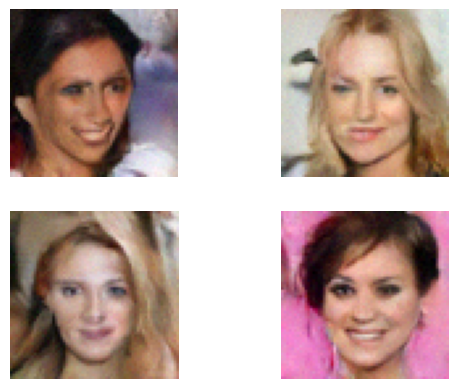

In [348]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)


images_blured = corruption(j[0]).cuda()
unblured_x = diffusion.p_sample_loop(model, images_blured)
out = ((2 * unblured_x - 1)  * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()


(ax1, ax2), (ax3, ax4)

ax1.imshow(out[0])
ax2.imshow(out[1])
ax3.imshow(out[2])
ax4.imshow(out[3])
ax4.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.savefig('generated_girls.pdf')
plt.show()


In [349]:
story = diffusion.saved_story

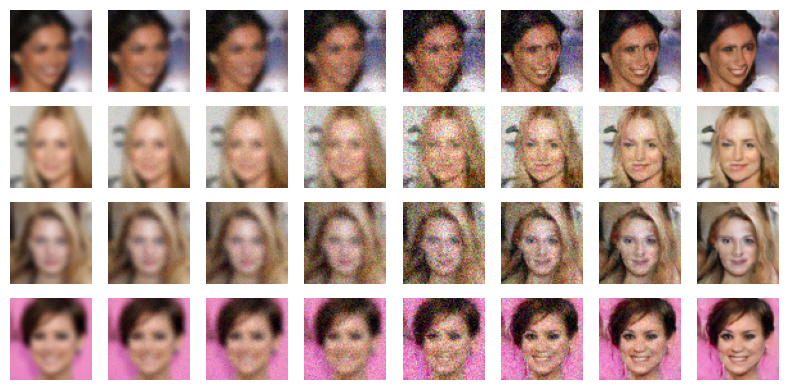

In [350]:
n = len(story)
m = len(story[0])

fig, axes = plt.subplots(m, n, figsize=(8, 4))

for i in range(n):
    for j in range(m):
        img_tensor = ((2 * story[i][j] - 1)  * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
        axes[j, i].imshow(img_tensor)
        axes[j, i].axis('off')

plt.tight_layout()
plt.savefig('trajectory_girls.pdf')
plt.show()

In [251]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)



ax1.imshow(j[0][0].permute(1, 2, 0))
ax2.imshow(j[0][1].permute(1, 2, 0))
ax3.imshow(j[0][2].permute(1, 2, 0))
ax4.imshow(j[0][3].permute(1, 2, 0))
plt.axis('off')
ax4.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.savefig('real_girls.pdf')
plt.show()


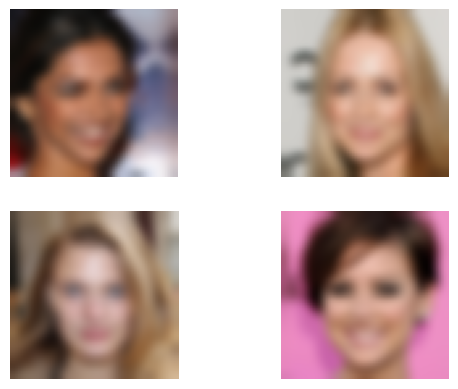

In [374]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)



ax1.imshow(corruption(j[0][0]).permute(1, 2, 0))
ax2.imshow(corruption(j[0][1]).permute(1, 2, 0))
ax3.imshow(corruption(j[0][2]).permute(1, 2, 0))
ax4.imshow(corruption(j[0][3]).permute(1, 2, 0))
plt.axis('off')
ax4.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.savefig('corrupt_girls.pdf')
plt.show()


## Out of sample generation

### 1. Sergey Kholkin

In [ ]:
def preprocess_image(image_path, target_size=(64, 64)):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(target_size)
    return image

In [108]:
image_SergeyKholkin = preprocess_image('/content/SergeyKholkin2.png')

In [109]:
transform_f = transforms.Compose([transforms.ToTensor()])



In [110]:
blured_image_SergeyKholkin = corruption(transform(image_SergeyKholkin).unsqueeze(0)).to('cuda')
unblured_image_SergeyKholkin = diffusion.p_sample_loop(model, blured_image_SergeyKholkin)

99it [00:00, 138.88it/s]


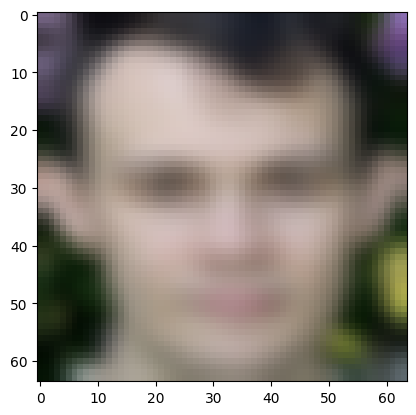

In [111]:
model.eval()
plt.imshow(((2 * blured_image_SergeyKholkin[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy())

In [119]:
blured_image_SergeyKholkin
blured_image_SergeyKholkin_mg = Image.fromarray(((2 * blured_image_SergeyKholkin[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy(), 'RGB')
blured_image_SergeyKholkin_mg.save("blured_image_SergeyKholkin1.jpg")

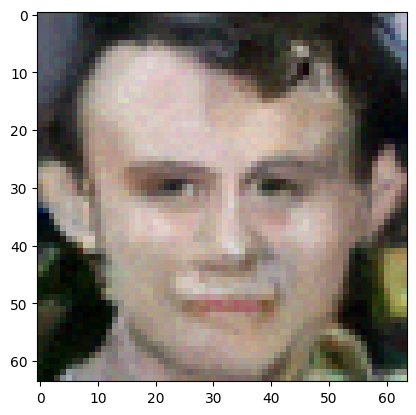

In [113]:
model.eval()
deblure_SergeyKholkin = ((2 * unblured_image_SergeyKholkin[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
plt.imshow(deblure_SergeyKholkin)

In [115]:
deblure_SergeyKholkin_mg = Image.fromarray(deblure_SergeyKholkin, 'RGB')

In [116]:
deblure_SergeyKholkin_mg.save("deblure_SergeyKholkin1.jpg")

## 2. Alexander Zaytsev

99it [00:00, 141.87it/s]


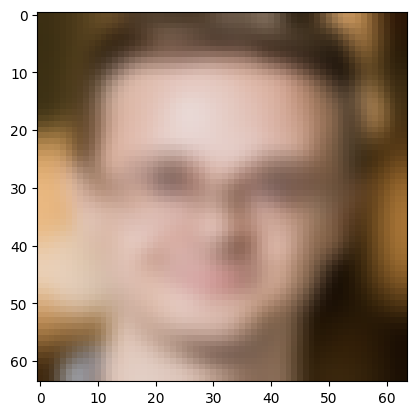

In [172]:
image_Zaytsev = preprocess_image('/content/Zaytsev.png')
transform_f = transforms.Compose([transforms.ToTensor()])
blured_image_Zaytsev = corruption(transform(image_Zaytsev).unsqueeze(0)).to('cuda')
unblured_image_Zaytsev = diffusion.p_sample_loop(model, blured_image_Zaytsev)
model.eval()
plt.imshow(((2 * blured_image_Zaytsev[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy())


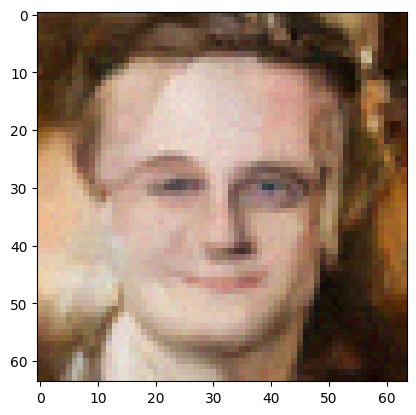

In [174]:
blured_image_Zaytsev_mg = Image.fromarray(((2 * blured_image_Zaytsev[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy(), 'RGB')
blured_image_Zaytsev_mg.save("blured_image_Zaytsev.jpg")
deblure_Zaytsev = ((2 * unblured_image_Zaytsev[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
plt.imshow(deblure_Zaytsev)


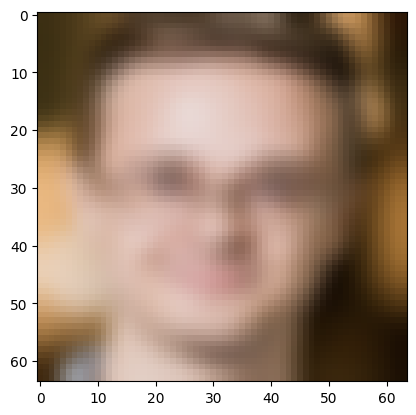

In [175]:
deblure_Zaytsev_mg = Image.fromarray(deblure_Zaytsev, 'RGB')
deblure_Zaytsev_mg.save("deblure_Zaytsev.jpg")
plt.imshow( corruption(image_Zaytsev))

## 3. Alexander Kolesov

99it [00:00, 110.02it/s]


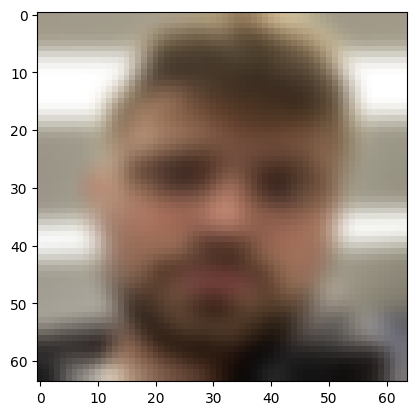

In [204]:
image_Kolesov = preprocess_image('/content/Kolesov.png')
transform_f = transforms.Compose([transforms.ToTensor()])
blured_image_Kolesov = corruption(transform(image_Kolesov).unsqueeze(0)).to('cuda')
unblured_image_Kolesov = diffusion.p_sample_loop(model, blured_image_Kolesov)
model.eval()
plt.imshow(((2 * blured_image_Kolesov[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy())


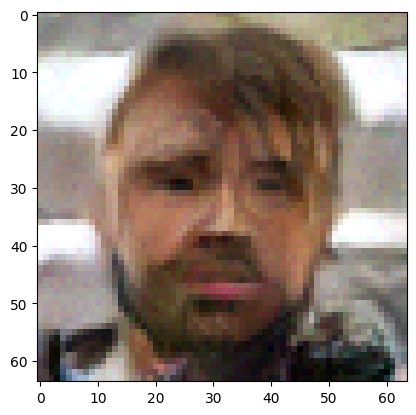

In [207]:
blured_image_Kolesov_mg = Image.fromarray(((2 * blured_image_Kolesov[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy(), 'RGB')
blured_image_Kolesov_mg.save("blured_image_Kolesov.jpg")
deblure_Kolesov = ((2 * unblured_image_Kolesov[0] - 1) * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
plt.imshow(deblure_Kolesov)


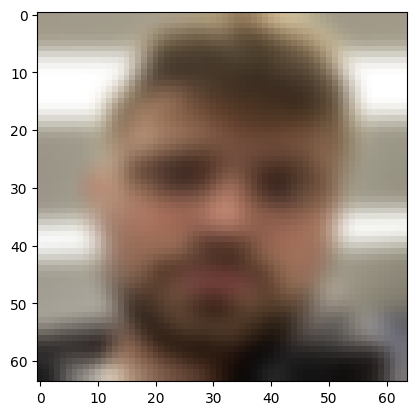

In [208]:
deblure_Kolesov_mg = Image.fromarray(deblure_Kolesov, 'RGB')
deblure_Kolesov_mg.save("deblure_Kolesov.jpg")
plt.imshow( corruption(image_Kolesov))